In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

/home/matthew/miniconda3/envs/snnenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


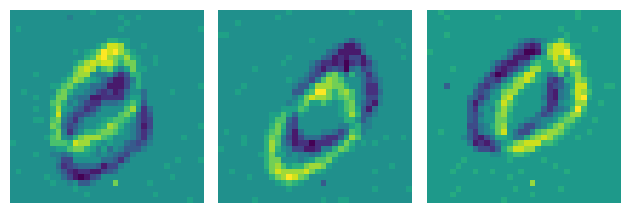

In [3]:
tonic.utils.plot_event_grid(events)

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, 
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

1.3 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.3 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [7]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

20 ms ± 1.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 20 ms ± 1.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [10]:
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)

In [11]:
#train1
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [12]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([311, 128, 2, 34, 34])


In [13]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [15]:
# this time, we won't return membrane as we don't need it 

def forward_pass(net, data):  
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [17]:
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets) 
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 30.96
Accuracy: 11.72%

Epoch 0, Iteration 1 
Train Loss: 30.96
Accuracy: 8.59%

Epoch 0, Iteration 2 
Train Loss: 31.00
Accuracy: 13.28%

Epoch 0, Iteration 3 
Train Loss: 31.00
Accuracy: 7.03%

Epoch 0, Iteration 4 
Train Loss: 23.06
Accuracy: 10.94%

Epoch 0, Iteration 5 
Train Loss: 12.19
Accuracy: 10.16%

Epoch 0, Iteration 6 
Train Loss: 16.24
Accuracy: 11.72%

Epoch 0, Iteration 7 
Train Loss: 17.27
Accuracy: 18.75%

Epoch 0, Iteration 8 
Train Loss: 16.68
Accuracy: 13.28%

Epoch 0, Iteration 9 
Train Loss: 14.03
Accuracy: 13.28%

Epoch 0, Iteration 10 
Train Loss: 12.28
Accuracy: 15.62%

Epoch 0, Iteration 11 
Train Loss: 13.67
Accuracy: 25.00%

Epoch 0, Iteration 12 
Train Loss: 14.85
Accuracy: 27.34%

Epoch 0, Iteration 13 
Train Loss: 13.13
Accuracy: 25.00%

Epoch 0, Iteration 14 
Train Loss: 12.54
Accuracy: 28.91%

Epoch 0, Iteration 15 
Train Loss: 12.88
Accuracy: 22.66%

Epoch 0, Iteration 16 
Train Loss: 13.44
Accuracy: 23.44%

Epoch 0, 

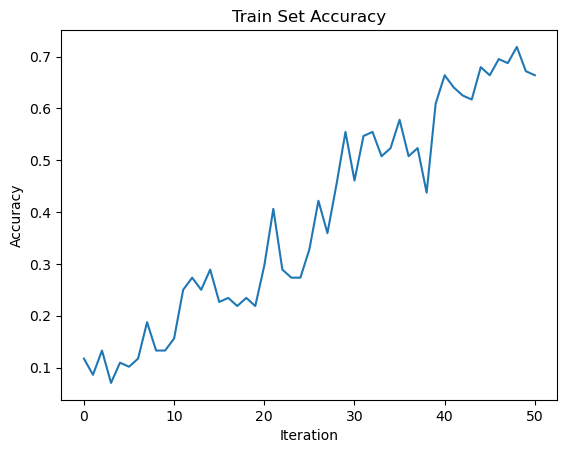

In [18]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [19]:
spk_rec = forward_pass(net, data)

The target label is: 5


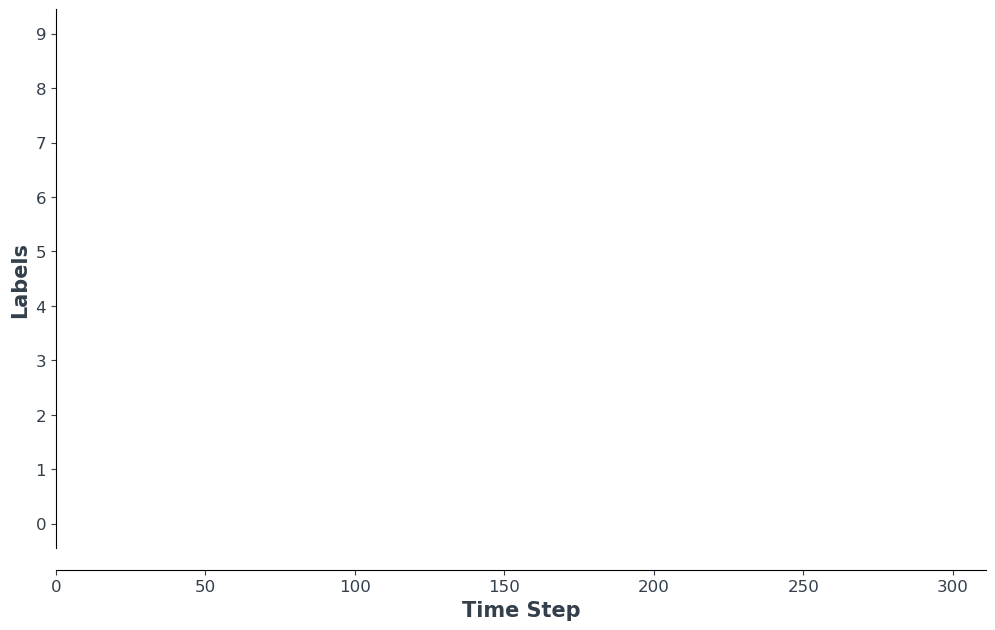

In [20]:
from IPython.display import HTML

idx = 1

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
anim.save("part7_6_spike_bar.mp4")

In [21]:
import numpy as np

# pick one example from batch
idx = 1  
spikes = spk_rec[:, idx].detach().cpu().numpy()  # shape: (timesteps, num_classes)
labels = ['0','1','2','3','4','5','6','7','8','9']

# convert spikes to 0/1 per timestep per output neuron
binary_spikes = (spikes > 0).astype(int)

# save as text file
np.savetxt("spike_output.txt", binary_spikes, fmt='%d', delimiter=',')

print("Saved spike sequence to spike_output.txt")
print("Each row = timestep, each column = neuron (0–9).")


Saved spike sequence to spike_output.txt
Each row = timestep, each column = neuron (0–9).
